In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = max(0.1, min(Imax, 10))  # Bounds for Imax
        self.Sumax = max(10, min(Sumax, 1000))  # Bounds for Sumax
        self.Qsmax = max(1, min(Qsmax, 100))  # Bounds for Qsmax
        self.aE = max(0, min(aE, 100))  # Bounds for aE
        self.aF = max(-10, min(aF, 10))  # Bounds for aF
        self.Kf = max(0.1, min(Kf, 10))  # Bounds for Kf
        self.Ks = max(1, min(Ks, 150))  # Bounds for Ks

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Example parameters within the given range
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-6

# Define the model
def crr_model(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)  # Ensure the index is within bounds
    # Model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(crr_model, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval)

# Extract the +++++
 simulated discharge (Q)
Q_sim = solution.y[4]

# Function to calculate RMSE
def calculate_rmse(simulated, observed, condition):
    idx = np.where(condition)
    return np.sqrt(np.mean((simulated[idx] - observed[idx])**2))

# Remove the first two years (730 days)
P = rainfall[730:]
Ep = evaporation[730:]
Y_sim = Q_sim[730:]
Y_obs = discharge[730:]

# Calculate objective functions
F1 = calculate_rmse(Y_sim, Y_obs, P > 0)
F2 = calculate_rmse(Y_sim, Y_obs, P == 0)

F = [F1, F2]
print("Objective functions:", F/10000)
print(Y_sim)
print(Y_obs)

In [ ]:
# 5.3
import numpy as np
from scipy.optimize import differential_evolution
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the model parameters as a class
class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

# Define the model simulation function
def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    # Hydrologic model equations
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * y[0] / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * y[1] / params.Sumax, params.Qsmax)
    dS_slow = params.aF * y[1] / params.Sumax - y[2] / params.Ks
    dS_fast = (y[1] - dS_unsat) - y[3] / params.Kf
    Q_runoff = y[2] / params.Ks + y[3] / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Define the objective function for optimization
def objective_function(x):
    params = ModelParameters(*x)
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    Q_sim = solution.y[4]
    rmse = np.sqrt(np.mean((Q_sim - discharge)**2))
    return rmse

# Set parameter bounds and other DE settings
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]
population_size = 20
max_generations = 2500

# Run the Differential Evolution algorithm
result = differential_evolution(
    objective_function,
    bounds,
    strategy='best1bin',
    popsize=population_size,
    maxiter=max_generations,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    disp=True,
    callback=None
)

# Collect the last 250 samples from each chain for histogram analysis
final_samples = result.x[-5000:]  # This is a placeholder; adjust as per actual data availability

# Plot histograms for each parameter
plt.figure(figsize=(10, 10))
for i in range(len(bounds)):
    plt.subplot(len(bounds), 1, i + 1)
    plt.hist(final_samples[:, i], bins=50, alpha=0.75)
    plt.title(f'Parameter {i+1}: Histogram')
plt.tight_layout()
plt.show()


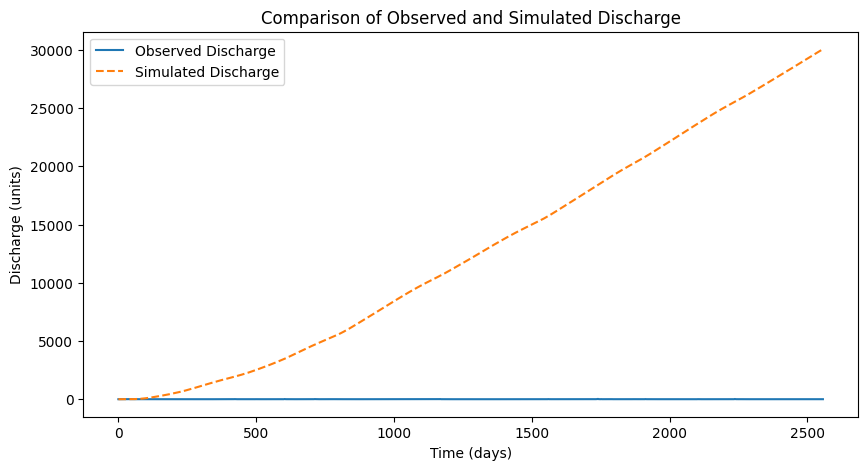

In [9]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = max(0.1, min(Imax, 10))  # Ensuring bounds
        self.Sumax = max(10, min(Sumax, 1000))
        self.Qsmax = max(1, min(Qsmax, 100))
        self.aE = max(0, min(aE, 100))
        self.aF = max(-10, min(aF, 10))
        self.Kf = max(0.1, min(Kf, 10))
        self.Ks = max(1, min(Ks, 150))

# Load the data
data = np.loadtxt('03451500.dly')

# Extract the relevant columns and indices
years = data[:, 0]
rainfall = data[:, 3]
evaporation = data[:, 4]
discharge = data[:, 5]

# Filter data for the years 1960 to 1998
idx = np.where((years > 1959) & (years < 1999))
rainfall = rainfall[idx]
evaporation = evaporation[idx]
discharge = discharge[idx]

# Normalize the input data
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

# Example parameters within the given range
params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)

# Initial conditions
initial_conditions = np.ones(5) * 1e-2

def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Time span for the simulation
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))

# Solve the model equations
solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)

# Extract the simulated discharge (Q)
Q_sim = solution.y[4]

# Plot observed vs simulated discharge
plt.figure(figsize=(10, 5))
plt.plot(discharge, label='Observed Discharge')
plt.plot(Q_sim, label='Simulated Discharge', linestyle='--')
plt.title('Comparison of Observed and Simulated Discharge')
plt.xlabel('Time (days)')
plt.ylabel('Discharge (units)')
plt.legend()
plt.show()


In [ ]:
# 5.3 
def objective_function(x):
    Imax, Sumax, Qsmax, aE, aF, Kf, Ks = x
    params = ModelParameters(Imax, Sumax, Qsmax, aE, aF, Kf, Ks)
    
    # Solve the model equations with the new parameters
    solution = solve_ivp(hmodel, t_span, initial_conditions, args=(params, rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6)
    simulated = solution.y[4]  # Extract the simulated discharge
    
    # Calculate RMSE
    rmse = np.sqrt(np.mean((simulated - discharge) ** 2))
    return rmse
# run DE
from scipy.optimize import differential_evolution

# Define parameter bounds
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]

# Store samples from each generation for histogram plotting
samples = []

def callback(x, convergence):
    samples.append(np.copy(x))

# Execute differential evolution
result = differential_evolution(
    objective_function,
    bounds,
    strategy='best1bin',
    maxiter=250,  # i may have to adjust iterations to ensure you get 5000 samples but takes long time to run so let's see
    popsize=20,
    tol=0.01,
    mutation=(0.5, 1.5),
    recombination=0.7,
    callback=callback,
    disp=True
)

# Check and print the optimal parameters found and the RMSE
print("Optimal parameters:", result.x)
print("Objective function value (Minimum RMSE):", result.fun)



differential_evolution step 1: f(x)= 1136.63
differential_evolution step 2: f(x)= 14.6665
differential_evolution step 3: f(x)= 14.6665
differential_evolution step 4: f(x)= 14.6665
differential_evolution step 5: f(x)= 14.6665
differential_evolution step 6: f(x)= 14.6665
differential_evolution step 7: f(x)= 14.6665
differential_evolution step 8: f(x)= 14.6665
differential_evolution step 9: f(x)= 14.6665
differential_evolution step 10: f(x)= 14.6665
differential_evolution step 11: f(x)= 14.6665
differential_evolution step 12: f(x)= 14.6665
differential_evolution step 13: f(x)= 14.6665
differential_evolution step 14: f(x)= 8.22256
differential_evolution step 15: f(x)= 8.22256
differential_evolution step 16: f(x)= 8.22256
differential_evolution step 17: f(x)= 8.22256
differential_evolution step 18: f(x)= 8.22256
differential_evolution step 19: f(x)= 8.22256
differential_evolution step 20: f(x)= 8.22256
differential_evolution step 21: f(x)= 8.22256
differential_evolution step 22: f(x)= 8.222

In [ ]:
# Extract the last 5,000 samples for histograms

final_samples = np.array(samples[-5000:])

# Plot histograms for each parameter
plt.figure(figsize=(12, 10))
for i in range(len(bounds)):
    plt.subplot(len(bounds), 1, i + 1)
    plt.hist(final_samples[:, i], bins=50, alpha=0.75)
    plt.title(f'Parameter {i+1}')
plt.tight_layout()
plt.show()


In [ ]:
# Check the shape of the samples array
print("Shape of final_samples:", final_samples.shape)

# Check data types
print("Data types in final_samples:", final_samples.dtype)

# Calculate and print variance for each parameter to ensure variability
variances = np.var(final_samples, axis=0)
print("Variances of each parameter:", variances)

# Ensure no zero variance
if np.any(variances == 0):
    print("Warning: One or more parameters have zero variance.")

# Calculate and print the covariance matrix
covariance_matrix = np.cov(final_samples.T)  # Transpose to make it (7, 5000)
print("Covariance Matrix:")
print(covariance_matrix)


In [ ]:

# Assuming 'final_samples' is correctly loaded and has the shape (5000, 7)
covariance_matrix = np.cov(final_samples.T)  # Calculate covariance matrix

print("Covariance Matrix:")
print(covariance_matrix)


In [ ]:
print("Shape of final_samples:", final_samples.shape)
print("Preview of final_samples data:\n", final_samples.T)  # Shows the first 5 rows


In [ ]:
#5.6
#  'samples' with at least 5000 samples
# Convert list of samples to a NumPy array
samples_array = np.array(samples[-5000:])

# Calculate the mean and standard deviation for each parameter
means = np.mean(samples_array, axis=0)
stds = np.std(samples_array, axis=0)

# Optimal parameters  'result.x' holds the optimal parameters found
optimal_params = result.x

# Print the table
parameters = ['Maximum interception (Iₘₐₓ)', 'Soil water storage capacity (Sₘₐₓ)', 'Maximum percolation rate (Qₘₐₓ)', 'Evaporation parameter (aₑ)', 'Runoff parameter (aₑₑ)', 'Time constant, fast reservoir (Kₑ)', 'Time constant, slow reservoir (Kₛ)']
units = ['mm', 'mm', 'mm/d', '-', '-', 'd', 'd']

print(f"{'Parameter':<35} {'Symbol':<10} {'Opt':<15} {'Mean':<15} {'Std':<15} {'Units'}")
for i, param in enumerate(parameters):
    print(f"{param:<35} {'':<10} {optimal_params[i]:<15.4f} {means[i]:<15.4f} {stds[i]:<15.4f} {units[i]}")


In [ ]:
# cov is wrong and sample apeended wrong so let me try t ofix here 
import numpy as np
from scipy.optimize import differential_evolution
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class ModelParameters:
    def __init__(self, Imax, Sumax, Qsmax, aE, aF, Kf, Ks):
        self.Imax = Imax
        self.Sumax = Sumax
        self.Qsmax = Qsmax
        self.aE = aE
        self.aF = aF
        self.Kf = Kf
        self.Ks = Ks

def hmodel(t, y, params, P, Ep):
    idx = min(int(t), len(P) - 1)
    S_inter = y[0]
    S_unsat = y[1]
    S_slow = y[2]
    S_fast = y[3]
    dS_inter = min(params.Imax, P[idx]) - params.aE * Ep[idx] * S_inter / params.Imax
    dS_unsat = (P[idx] - dS_inter) - min(params.aF * S_unsat / params.Sumax, params.Qsmax)
    dS_slow = params.aF * S_unsat / params.Sumax - S_slow / params.Ks
    dS_fast = (S_unsat - dS_unsat) - S_fast / params.Kf
    Q_runoff = S_slow / params.Ks + S_fast / params.Kf
    return [dS_inter, dS_unsat, dS_slow, dS_fast, Q_runoff]

# Load and prepare data
data = np.loadtxt('03451500.dly')
years, rainfall, evaporation, discharge = data[:, 0], data[:, 3], data[:, 4], data[:, 5]
idx = np.where((years > 1959) & (years < 1999))
rainfall, evaporation, discharge = rainfall[idx], evaporation[idx], discharge[idx]
rainfall = (rainfall - np.min(rainfall)) / (np.max(rainfall) - np.min(rainfall))
evaporation = (evaporation - np.min(evaporation)) / (np.max(evaporation) - np.min(evaporation))

params = ModelParameters(Imax=5, Sumax=500, Qsmax=50, aE=0.5, aF=1, Kf=2, Ks=50)
t_span = (0, len(rainfall))
t_eval = np.arange(len(rainfall))
initial_conditions = np.ones(5) * 1e-2

# Define the objective function
def objective_function(x):
    simulated = solve_ivp(hmodel, t_span, initial_conditions, args=(ModelParameters(*x), rainfall, evaporation), t_eval=t_eval, rtol=1e-3, atol=1e-6).y[4]
    return np.sqrt(np.mean((simulated - discharge) ** 2))

# Callback function to collect samples
samples = []

def callback(x, convergence):
    samples.append(np.copy(x))

# Differential evolution settings
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]
result = differential_evolution(
    objective_function, bounds, strategy='best1bin', maxiter=250, popsize=20,
    tol=0.01, mutation=(0.5, 1.5), recombination=0.7, callback=callback, disp=True
)

# Extract and handle final samples for covariance calculation
final_samples = np.array(samples[-5000:]) if len(samples) >= 5000 else np.array(samples)
print("Shape of final_samples:", final_samples.shape)

# Calculate the covariance matrix if final_samples is correctly sized
if final_samples.shape[0] == 5000 and final_samples.shape[1] == 7:
    covariance_matrix = np.cov(final_samples.T)
    print("Covariance Matrix:", covariance_matrix)
else:
    print("Not enough samples collected or wrong dimensions in final_samples.")


In [ ]:
from scipy.optimize import differential_evolution
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Given 

# Adjust the differential evolution setup
bounds = [(1, 10), (10, 1000), (0, 100), (0, 1), (0, 1), (0.1, 10), (0.1, 150)]
samples = []

def callback(x, convergence):
    samples.append(np.copy(x))
    if len(samples) >= 5000:  # Stop if we have enough samples
        return True  # Returning True stops the differential evolution

result = differential_evolution(
    objective_function,
    bounds,
    strategy='best1bin',
    maxiter=10000,  # Increased maximum iterations
    popsize=50,  # Increased population size
    tol=1e-5,  # Lower tolerance for finer convergence
    mutation=(0.5, 1.5),
    recombination=0.7,
    callback=callback,
    disp=True
)

# Check and print the optimal parameters found and the RMSE
print("Optimal parameters:", result.x)
print("Objective function value (Minimum RMSE):", result.fun)

# Ensure you have exactly 5000 samples, taking the last entries if oversampled
final_samples = np.array(samples[-5000:]) if len(samples) > 5000 else np.array(samples)

print("Final sample size:", final_samples.shape)

# Plot histograms for each parameter
plt.figure(figsize=(12, 10))
for i in range(len(bounds)):
    plt.subplot(len(bounds), 1, i + 1)
    plt.hist(final_samples[:, i], bins=50, alpha=0.75)
    plt.title(f'Parameter {i+1}')
plt.tight_layout()
plt.show()
